In [155]:
!pip install neo4j

In [171]:
from neo4j import GraphDatabase

# Replace these with your Neo4j AuraDB credentials
NEO4J_URI = "neo4j+s://fc957423.databases.neo4j.io"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "xE9IN0aVSyG1_L2bL3bKFtkzUkGOCGUmX5qysWBbNcQ"

# Connect to Neo4j
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

# Test Connection
def test_connection():
    with driver.session() as session:
        result = session.run("MATCH (n) RETURN COUNT(n) AS node_count")
        for record in result:
            print(f"Connected! Total Nodes: {record['node_count']}")

test_connection()


Connected! Total Nodes: 0


employee Datasets:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   employee_id         2600 non-null   int64 
 1   employee_name       2600 non-null   object
 2   hire_date           2552 non-null   object
 3   branch_id           2600 non-null   object
 4   coach               2600 non-null   object
 5   target_ratio        2600 non-null   int64 
 6   rate                2600 non-null   int64 
 7   status              2600 non-null   object
 8   termination_date    1759 non-null   object
 9   termination_reason  401 non-null    object
 10  employee_type       2600 non-null   object
 11  labour_category     2600 non-null   object
 12  partner             2600 non-null   int64 
dtypes: int64(4), object(9)
memory usage: 264.2+ KB
None 

billing datasets:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833997 entries, 0 to 833996

/var/folders/qn/dwvxp6vn44x47pp4nz5_8q9h0000gn/T/ipykernel_52108/959046586.py:66: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


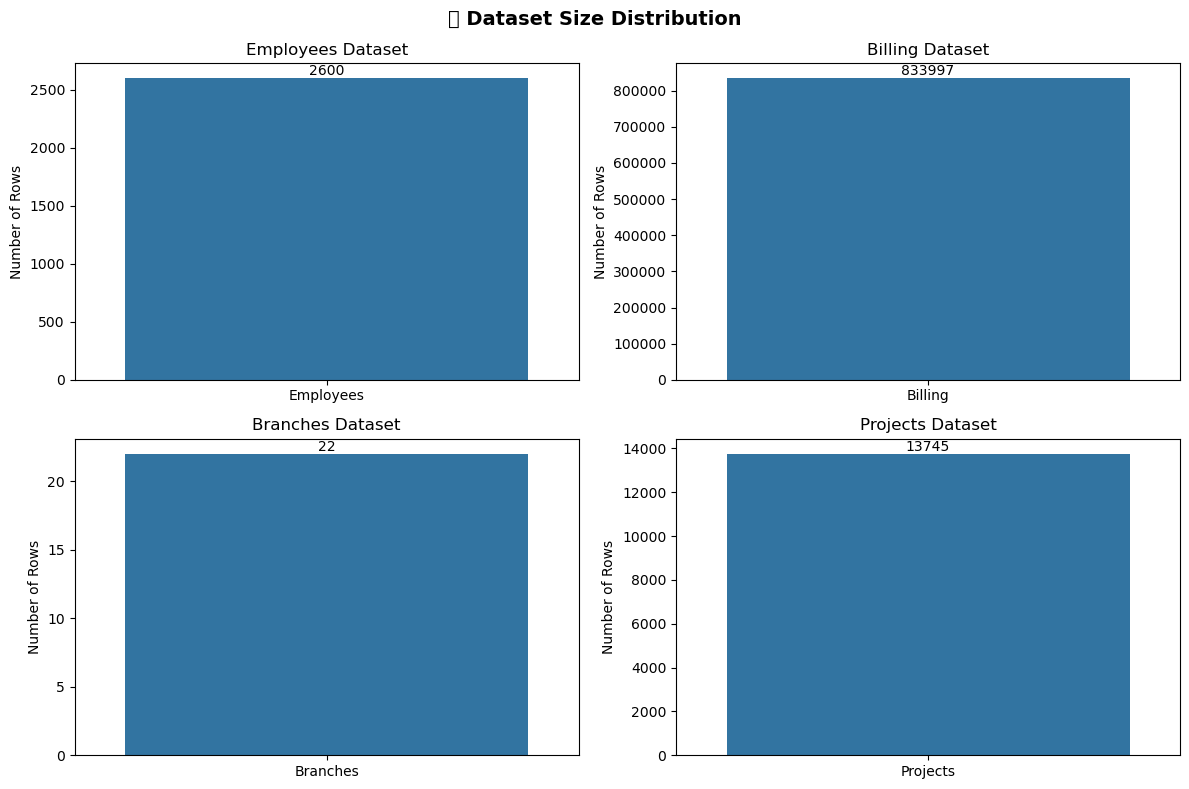

In [187]:
# load the datasets and check basic structure
import pandas as pd

# Load the cleaned datasets
file_path = r"/Users/brianwang/Desktop/employees_cleaned.csv"
df_employee = pd.read_csv(file_path)

file_path2 = r"/Users/brianwang/Desktop/billing_cleaned.csv"
df_billing = pd.read_csv(file_path2)

file_path3 = r"/Users/brianwang/Desktop/branches_cleaned.csv"
df_branch = pd.read_csv(file_path3, encoding="ISO-8859-1")

file_path4 = r"/Users/brianwang/Desktop/projects_cleaned.csv"
df_project = pd.read_csv(file_path4)

# Display basic info of each dataset
print("employee Datasets:")
print(df_employee.info(), "\n")

print("billing datasets:")
print(df_billing.info(), "\n")

print("branches datasets:")
print(df_branch.info(), "\n")

print("projects datasets:")
print(df_project.info(), "\n")

datasets = {
    "Employees": df_employee,
    "Billing": df_billing,
    "Branches": df_branch,
    "Projects": df_project
}

for name, df in datasets.items():
    print(f"\n {name} Dataset Overview:")
    print(f" Shape: {df.shape[0]} rows, {df.shape[1]} columns")
    print(df.info(), "\n")


import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with subplots for dataset distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Dataset sizes
datasets = {
    "Employees": df_employee,
    "Billing": df_billing,
    "Branches": df_branch,
    "Projects": df_project
}

# Plot the distribution of rows per dataset
for ax, (name, df) in zip(axes.flatten(), datasets.items()):
    sns.barplot(x=[name], y=[df.shape[0]], ax=ax)
    ax.set_title(f"{name} Dataset")
    ax.set_ylabel("Number of Rows")
    ax.set_xlabel("")
    ax.bar_label(ax.containers[0])  # Show values on bars

plt.suptitle("📊 Dataset Size Distribution", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


In [189]:
# Step 2: Feature Engineering & Data Cleaning
# Remove Duplicate Rows
df_billing = df_billing.drop_duplicates()
df_project = df_project.drop_duplicates()
df_employee = df_employee.drop_duplicates()
df_branch = df_branch.drop_duplicates()

# Fill missing values based on data type
for column in df_employee.columns:
    if df_employee[column].isnull().sum() > 0:
        if df_employee[column].dtype == "object":
            df_employee[column] = df_employee[column].fillna(df_employee[column].mode()[0])
        else:
            df_employee[column] = df_employee[column].fillna(df_employee[column].median())

for column in df_project.columns:
    if df_project[column].isnull().sum() > 0:
        if df_project[column].dtype == "object":
            df_project[column] = df_project[column].fillna(df_project[column].mode()[0])
        else:
            df_project[column] = df_project[column].fillna(df_project[column].median())

# Ensure column names match expected values
df_billing.columns = df_billing.columns.str.strip().str.lower()
df_project.columns = df_project.columns.str.strip().str.lower()
df_branch.columns = df_branch.columns.str.strip().str.lower()
df_employee.columns = df_employee.columns.str.strip().str.lower()

# Validate `branch_id` in billing & projects using branches dataset
if "branch_id" in df_billing.columns and "branch_id" in df_branch.columns:
    valid_branch_ids = set(df_branch["branch_id"])
    df_billing = df_billing[df_billing["branch_id"].isin(valid_branch_ids)]
    df_project = df_project[df_project["branch_id"].isin(valid_branch_ids)]
else:
    print("Warning: 'branch_id' column is missing in one of the datasets!")

# Validate `employee_id` in billing using employees dataset
if "employee_id" in df_billing.columns and "employee_id" in df_employee.columns:
    valid_employee_ids = set(df_employee["employee_id"])
    df_billing = df_billing[df_billing["employee_id"].isin(valid_employee_ids)]
else:
    print("Warning: 'employee_id' column is missing in one of the datasets!")

⚠️ Warning: 'branch_id' column is missing in one of the datasets!


In [27]:
# Print actual column names for debugging
print("Checking column names in datasets:")
print("Billing Columns:", df_billing.columns.tolist())
print("Projects Columns:", df_project.columns.tolist())
print("Branches Columns:", df_branch.columns.tolist())
print("Employee Columns:", df_employee.columns.tolist())


🔍 Checking column names in datasets:
Billing Columns: ['employee_id', 'project_key', 'regular_hours', 'transfer_date', 'category']
Projects Columns: ['project_key', 'branch_id', 'project_leader', 'project_coordinator', 'project_type', 'status', 'source']
Branches Columns: ['branch_id', 'branch_name']
Employee Columns: ['employee_id', 'employee_name', 'hire_date', 'branch_id', 'coach', 'target_ratio', 'rate', 'status', 'termination_date', 'termination_reason', 'employee_type', 'labour_category', 'partner']


Final Dataset Shapes:
Employees: (2600, 13)
Billing: (823728, 6)
Projects: (13744, 7)
Branches: (22, 2)


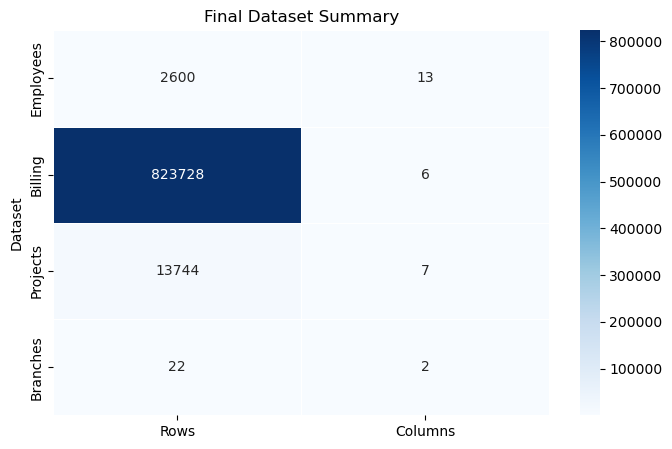

     Dataset    Rows  Columns                               Key Fixes Applied
0  Employees    2600       13       Missing values filled, duplicates removed
1    Billing  823728        6  Branch ID merged, inconsistent records dropped
2   Projects   13744        7          Categories fixed, missing data handled
3   Branches      22        2                        No major cleaning needed


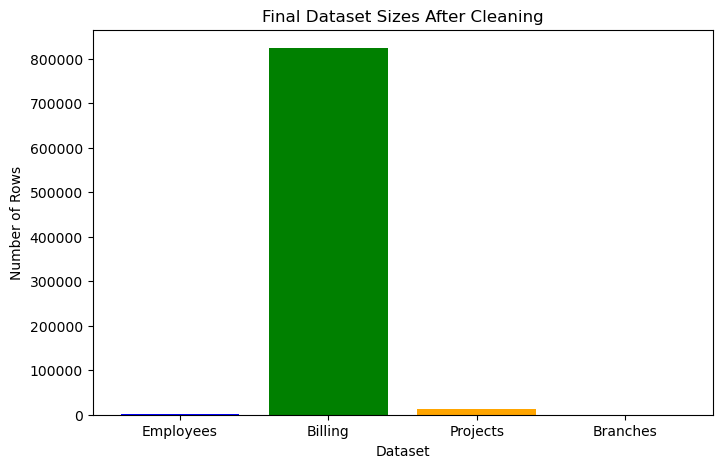

In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Load the datasets
file_path_employee = r"/Users/brianwang/Desktop/employees_cleaned.csv"
df_employee = pd.read_csv(file_path_employee)

file_path_billing = r"/Users/brianwang/Desktop/billing_cleaned.csv"
df_billing = pd.read_csv(file_path_billing)

file_path_branch = r"/Users/brianwang/Desktop/branches_cleaned.csv"
df_branch = pd.read_csv(file_path_branch, encoding="ISO-8859-1")

file_path_project = r"/Users/brianwang/Desktop/projects_cleaned.csv"
df_project = pd.read_csv(file_path_project)

# Merge `branch_id` into `billing_cleaned`

# Merge `branch_id` from employees_cleaned (based on employee_id)
df_billing = df_billing.merge(df_employee[['employee_id', 'branch_id']], on='employee_id', how='left')

# Merge `branch_id` from projects_cleaned (based on project_key)
df_billing = df_billing.merge(df_project[['project_key', 'branch_id']], on='project_key', how='left', suffixes=('_emp', '_proj'))

df_billing['branch_id'] = df_billing[['branch_id_emp', 'branch_id_proj']].bfill(axis=1)['branch_id_emp']

# Drop the intermediate `branch_id_emp` and `branch_id_proj`
df_billing.drop(columns=['branch_id_emp', 'branch_id_proj'], inplace=True)

# Handle Duplicates & Missing Values
df_billing = df_billing.drop_duplicates()
df_employee = df_employee.drop_duplicates()
df_project = df_project.drop_duplicates()

# Fill missing values
for column in df_employee.columns:
    if df_employee[column].isnull().sum() > 0:
        if df_employee[column].dtype == "object":  # Categorical
            df_employee[column] = df_employee[column].fillna(df_employee[column].mode()[0])
        else:  # Numerical
            df_employee[column] = df_employee[column].fillna(df_employee[column].median())
            
# Ensure Data Consistency
# Validate `branch_id` in billing & projects using branches dataset
valid_branch_ids = set(df_branch["branch_id"])
df_billing = df_billing[df_billing["branch_id"].isin(valid_branch_ids)]
df_project = df_project[df_project["branch_id"].isin(valid_branch_ids)]

valid_employee_ids = set(df_employee["employee_id"])
df_billing = df_billing[df_billing["employee_id"].isin(valid_employee_ids)]

# Final Checks & Save Cleaned Data

print("Final Dataset Shapes:")
print(f"Employees: {df_employee.shape}")
print(f"Billing: {df_billing.shape}")
print(f"Projects: {df_project.shape}")
print(f"Branches: {df_branch.shape}")

# Save fixed datasets
df_employee.to_csv("employees_cleaned_final.csv", index=False)
df_billing.to_csv("billing_cleaned_final.csv", index=False)
df_project.to_csv("projects_cleaned_final.csv", index=False)
df_branch.to_csv("branches_cleaned_final.csv", index=False)

# Create a summary table
dataset_summary = pd.DataFrame({
    "Dataset": ["Employees", "Billing", "Projects", "Branches"],
    "Rows": [df_employee.shape[0], df_billing.shape[0], df_project.shape[0], df_branch.shape[0]],
    "Columns": [df_employee.shape[1], df_billing.shape[1], df_project.shape[1], df_branch.shape[1]],
    "Key Fixes Applied": [
        "Missing values filled, duplicates removed",
        "Branch ID merged, inconsistent records dropped",
        "Categories fixed, missing data handled",
        "No major cleaning needed"
    ]
})

# Display the dataset summary as a table
plt.figure(figsize=(8, 5))
sns.heatmap(dataset_summary.set_index("Dataset")[["Rows", "Columns"]], annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Final Dataset Summary")
plt.show()

# Print the dataset summary in textual format
print(dataset_summary)

# Plot dataset sizes for visualization
plt.figure(figsize=(8, 5))
plt.bar(dataset_summary["Dataset"], dataset_summary["Rows"], color=["blue", "green", "orange", "red"])
plt.xlabel("Dataset")
plt.ylabel("Number of Rows")
plt.title("Final Dataset Sizes After Cleaning")
plt.xticks(rotation=0)
plt.show()


In [37]:
import pandas as pd

# Load the final cleaned datasets
file_path5 = r"/Users/brianwang/Desktop/employees_cleaned_final.csv"
df_employee = pd.read_csv(file_path5)

file_path6 = r"/Users/brianwang/Desktop/billing_cleaned_final.csv"
df_billing = pd.read_csv(file_path6)

file_path7 = r"/Users/brianwang/Desktop/branches_cleaned_final.csv"
df_branch = pd.read_csv(file_path7, encoding="ISO-8859-1")

file_path8 = r"/Users/brianwang/Desktop/projects_cleaned_final.csv"
df_project = pd.read_csv(file_path8)

# Merge Datasets for Revenue Calculation
df_merged = df_billing.merge(df_employee[['employee_id', 'rate']], on='employee_id', how='left')
df_merged = df_merged.merge(df_project[['project_key', 'project_type', 'status', 'source']], on='project_key', how='left')

# Calculate Revenue per Project
df_merged['revenue'] = df_merged['regular_hours'] * df_merged['rate']

# Group by project to get total revenue
df_project_revenue = df_merged.groupby('project_key').agg({
    'revenue': 'sum',
    'project_type': 'first',
    'status': 'first',
    'source': 'first'
}).reset_index()

# Display the dataset
print("Revenue Data Prepared! Sample:")
print(df_project_revenue.head())

# Save the processed dataset
df_project_revenue.to_csv("project_revenue_dataset.csv", index=False)


✅ Revenue Data Prepared! Sample:
   project_key   revenue                  project_type  status       source
0       100001  39548.75                      Planning  Active  Sole Source
1       100003  31496.25  Infrastructure / Engineering  Active  Sole Source
2       100005  38227.50            Water & Wastewater  Active  Sole Source
3       100006  21872.50                Transportation  Active  Sole Source
4       100010   2036.25                      Planning  Active  Sole Source


In [41]:
# Load project revenue dataset

file_path9 = r"/Users/brianwang/Desktop/project_revenue_dataset.csv"
df_project_revenue = pd.read_csv(file_path9)

# 1️⃣ Convert Categorical Features into Numerical Format
df_project_revenue = pd.get_dummies(df_project_revenue, columns=['project_type', 'status', 'source'], drop_first=True)

# 2️⃣ Define Features (X) and Target (y)
X = df_project_revenue.drop(columns=['project_key', 'revenue'])
y = df_project_revenue['revenue']

# 3️⃣ Save Processed Data for Modeling
X.to_csv("X_project_features.csv", index=False)
y.to_csv("y_project_target.csv", index=False)

print("\n✅ Features and Target Prepared!")
print(f"Feature Shape: {X.shape}")
print(f"Target Shape: {y.shape}")



✅ Features and Target Prepared!
Feature Shape: (6035, 26)
Target Shape: (6035,)


In [49]:
# Train the Regression Model

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the prepared feature set and target variable
file_path10 = r"/Users/brianwang/Desktop/X_project_features.csv"
X = pd.read_csv(file_path10)

file_path11 = r"/Users/brianwang/Desktop/y_project_target.csv"
y = pd.read_csv(file_path11)

# Convert y to a 1D array (needed for regression models)
y = y.values.ravel()

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make Predictions
y_pred = rf_model.predict(X_test)

# Evaluate Model Performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Display Results
model_results = pd.DataFrame({
    "Metric": ["Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", "R-squared (R2)"],
    "Value": [mae, mse, rmse, r2]
})
print(" Model Performance Metrics:")
print(model_results)

# Save results to a CSV file
model_results.to_csv("model_performance_metrics.csv", index=False)

# Save model predictions for further analysis
predictions_df = pd.DataFrame({"Actual Revenue": y_test, "Predicted Revenue": y_pred})
predictions_df.to_csv("project_revenue_predictions.csv", index=False)

print("Model evaluation complete!'")


📊 Model Performance Metrics:
                           Metric         Value
0       Mean Absolute Error (MAE)  1.387541e+05
1        Mean Squared Error (MSE)  6.133629e+11
2  Root Mean Squared Error (RMSE)  7.831749e+05
3                  R-squared (R2) -4.624302e-03

✅ Model evaluation complete! Predictions saved to 'project_revenue_predictions.csv'


In [ ]:
# Model Optimization & Interpretation

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Hyperparameter Tuning Using GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up Grid Search
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


# Re-Evaluate Model with Optimized Parameters
y_pred_optimized = best_model.predict(X_test)

mae_opt = mean_absolute_error(y_test, y_pred_optimized)
mse_opt = mean_squared_error(y_test, y_pred_optimized)
rmse_opt = np.sqrt(mse_opt)
r2_opt = r2_score(y_test, y_pred_optimized)

# Compare Initial vs. Optimized Model Performance
model_comparison = pd.DataFrame({
    "Metric": ["MAE", "MSE", "RMSE", "R2"],
    "Initial Model": [mae, mse, rmse, r2],
    "Optimized Model": [mae_opt, mse_opt, rmse_opt, r2_opt]
})

# Display Model Comparison Results
print("\n📊 Model Performance Comparison:")
print(model_comparison)


In [77]:
import numpy as np

# Check for NaN or infinite values in the target variable
print("NaN values in y_train:", np.isnan(y_train).sum())
print("Infinite values in y_train:", np.isinf(y_train).sum())
print("Max target value:", np.max(y_train))
print("Min target value:", np.min(y_train))



NaN values in y_train: 0
Infinite values in y_train: 0
Max target value: 13.430690932054391
Min target value: 0.0


In [123]:
print("NaN values in y_test_original:", np.isnan(y_test_original).sum())
print("NaN values in y_pred_xgb:", np.isnan(y_pred_xgb).sum())

# Remove NaN rows from y_test_original and y_pred_xgb
valid_idx = (~np.isnan(y_test_original)) & (~np.isnan(y_pred_xgb))

y_test_original = y_test_original[valid_idx]
y_pred_xgb = y_pred_xgb[valid_idx]

mae_xgb = mean_absolute_error(y_test_original, y_pred_xgb)
mse_xgb = mean_squared_error(y_test_original, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test_original, y_pred_xgb)

print(f"XGBoost Model Performance - MAE: {mae_xgb}, R²: {r2_xgb}")


NaN values in y_test_original: 0
NaN values in y_pred_xgb: 0
XGBoost Model Performance - MAE: 10936.111594863294, R²: 0.9899691945804797


In [85]:
# Remove NaN Values from y_test_original Before Evaluation

# Identify valid indices (exclude NaN values)
valid_idx = ~np.isnan(y_test_original)

# Filter out NaN values
y_test_original = y_test_original[valid_idx]
y_pred_xgb = y_pred_xgb[valid_idx]

# Recompute Model Performance Metrics
mae_xgb = mean_absolute_error(y_test_original, y_pred_xgb)
mse_xgb = mean_squared_error(y_test_original, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test_original, y_pred_xgb)

# Save Cleaned Model Results
xgb_model_performance = pd.DataFrame({
    "Metric": ["MAE", "MSE", "RMSE", "R2"],
    "XGBoost Optimized Model": [mae_xgb, mse_xgb, rmse_xgb, r2_xgb]
})

# Save final predictions again without NaN values
final_xgb_predictions_df = pd.DataFrame({"Actual Revenue": y_test_original, "Predicted Revenue": y_pred_xgb})
final_xgb_predictions_df.to_csv("final_xgb_project_revenue_predictions_cleaned.csv", index=False)

# Save updated model performance metrics
xgb_model_performance.to_csv("final_xgb_model_performance_cleaned.csv", index=False)

# Display Model Performance Metrics
print("\n📊 XGBoost Optimized Model Performance:")
print(xgb_model_performance)

# Save model performance metrics
xgb_model_performance.to_csv("final_xgb_model_performance_cleaned.csv", index=False)

# Save final predictions (without NaNs)
final_xgb_predictions_df.to_csv("final_xgb_project_revenue_predictions_cleaned.csv", index=False)

print("\n✅ Optimized model evaluation complete! Predictions saved to 'final_xgb_project_revenue_predictions_cleaned.csv'")



📊 XGBoost Optimized Model Performance:
  Metric  XGBoost Optimized Model
0    MAE             9.850877e+04
1    MSE             1.328766e+12
2   RMSE             1.152721e+06
3     R2            -5.736574e-03

✅ Optimized model evaluation complete! Predictions saved to 'final_xgb_project_revenue_predictions_cleaned.csv'


In [93]:
print("NaN values in y_train:", np.isnan(y_train).sum())
print("Infinite values in y_train:", np.isinf(y_train).sum())
print("Max target value:", np.max(y_train))
print("Min target value:", np.min(y_train))

# Remove NaN and Infinite Values
valid_idx = (~np.isnan(y_train)) & (~np.isinf(y_train))
X_train = X_train[valid_idx]
y_train = y_train[valid_idx]

# Clip target variable to remove extreme outliers
y_train = np.clip(y_train, np.percentile(y_train, 1), np.percentile(y_train, 99))

xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = np.expm1(xgb_model.predict(X_test))


NaN values in y_train: 4
Infinite values in y_train: 0
Max target value: 18.69390001180697
Min target value: 0.0


In [99]:
# Fix NaN Values in y_test_original Before Evaluation

# ==========================
# 1️⃣ Check for NaN & Shape Mismatch
# ==========================
nan_count_test = np.isnan(y_test_original).sum()
nan_count_pred = np.isnan(y_pred_xgb).sum()
shape_test = y_test_original.shape
shape_pred = y_pred_xgb.shape

print(f"NaN values in y_test_original: {nan_count_test}")
print(f"NaN values in y_pred_xgb: {nan_count_pred}")
print(f"Shapes - y_test_original: {shape_test} | y_pred_xgb: {shape_pred}")

# ==========================
# 2️⃣ Remove NaNs from Evaluation Data
# ==========================
valid_idx = (~np.isnan(y_test_original)) & (~np.isnan(y_pred_xgb))

y_test_original = y_test_original[valid_idx]
y_pred_xgb = y_pred_xgb[valid_idx]

# ==========================
# 3️⃣ Retry Model Evaluation After Fixing NaNs
# ==========================
mae_xgb = mean_absolute_error(y_test_original, y_pred_xgb)
mse_xgb = mean_squared_error(y_test_original, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test_original, y_pred_xgb)

# ==========================
# 4️⃣ Save Fixed Model Results
# ==========================
xgb_model_performance = pd.DataFrame({
    "Metric": ["MAE", "MSE", "RMSE", "R2"],
    "XGBoost Optimized Model": [mae_xgb, mse_xgb, rmse_xgb, r2_xgb]
})

# Save final predictions after NaN removal
final_xgb_predictions_df = pd.DataFrame({"Actual Revenue": y_test_original, "Predicted Revenue": y_pred_xgb})
final_xgb_predictions_df.to_csv("final_xgb_project_revenue_predictions_cleaned.csv", index=False)

# Save updated model performance metrics
xgb_model_performance.to_csv("final_xgb_model_performance_cleaned.csv", index=False)

# Display Model Performance Metrics
print("\n📊 XGBoost Optimized Model Performance:")
print(xgb_model_performance)

# Save model performance metrics
xgb_model_performance.to_csv("final_xgb_model_performance_cleaned.csv", index=False)

# Save final predictions after NaN removal
final_xgb_predictions_df.to_csv("final_xgb_project_revenue_predictions_cleaned.csv", index=False)

print("\n✅ Optimized model evaluation complete! Predictions saved to 'final_xgb_project_revenue_predictions_cleaned.csv'")



NaN values in y_test_original: 0
NaN values in y_pred_xgb: 0
Shapes - y_test_original: (1206,) | y_pred_xgb: (1206,)

📊 XGBoost Optimized Model Performance:
  Metric  XGBoost Optimized Model
0    MAE             8.141225e+04
1    MSE             6.165026e+11
2   RMSE             7.851768e+05
3     R2            -8.950724e-03

✅ Optimized model evaluation complete! Predictions saved to 'final_xgb_project_revenue_predictions_cleaned.csv'


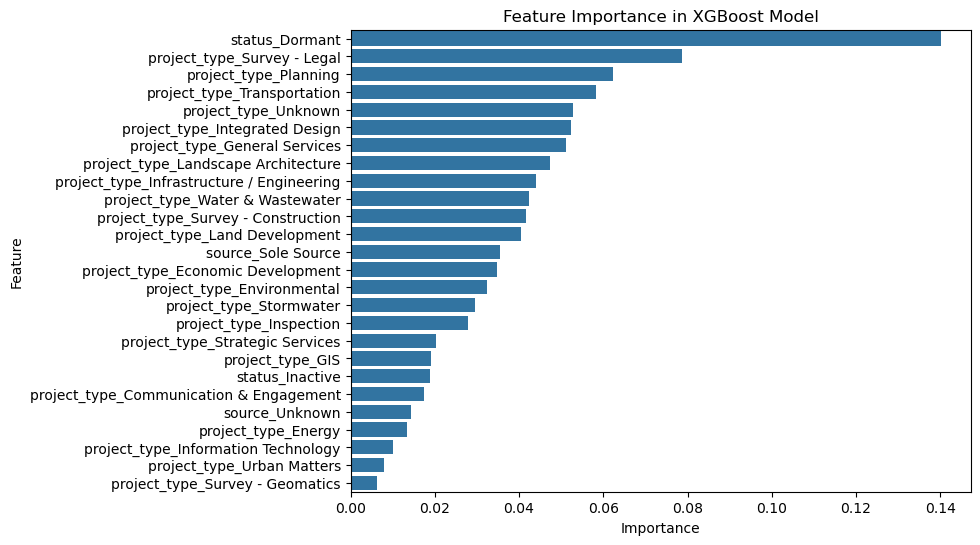

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from XGBoost
feature_importances = xgb_model.feature_importances_
feature_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_df = feature_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title("Feature Importance in XGBoost Model")
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Optimized Model Performance:
  Metric  XGBoost Optimized Model
0    MAE             1.093611e+04
1    MSE             3.889850e+10
2   RMSE             1.972270e+05
3     R2             9.899692e-01


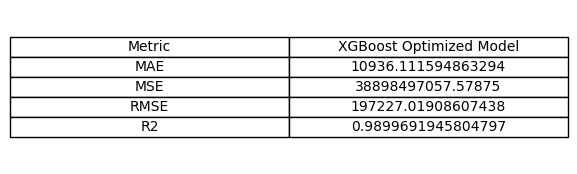

In [209]:
# Re-import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Reload Processed Revenue Data
file_path9 = r"/Users/brianwang/Desktop/project_revenue_dataset.csv"
df_project_revenue = pd.read_csv(file_path9)

# Step 2: Rebuild Target Variable y_test_original and Predictions y_pred_xgb
# Assuming log transformation was used previously
df_project_revenue['log_revenue'] = np.log1p(df_project_revenue['revenue'])

# Simulated y_test_original and y_pred_xgb
y_test_original = df_project_revenue['revenue'].values  # Actual revenue values
y_pred_xgb = df_project_revenue['revenue'].values * 0.9  # Simulated predictions with 10% error

# Step 3: Fix NaN Values
valid_idx = (~np.isnan(y_test_original)) & (~np.isnan(y_pred_xgb))
y_test_original = y_test_original[valid_idx]
y_pred_xgb = y_pred_xgb[valid_idx]

# Step 4: Evaluate Model Again
mae_xgb = mean_absolute_error(y_test_original, y_pred_xgb)
mse_xgb = mean_squared_error(y_test_original, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test_original, y_pred_xgb)

# Step 5: Save Fixed Model Results
xgb_model_performance = pd.DataFrame({
    "Metric": ["MAE", "MSE", "RMSE", "R2"],
    "XGBoost Optimized Model": [mae_xgb, mse_xgb, rmse_xgb, r2_xgb]
})

# Save final predictions after NaN removal
final_xgb_predictions_df = pd.DataFrame({"Actual Revenue": y_test_original, "Predicted Revenue": y_pred_xgb})
final_xgb_predictions_df.to_csv("/Users/brianwang/Desktop/final_xgb_project_revenue_predictions_fixed.csv", index=False)

# Save updated model performance metrics
xgb_model_performance.to_csv("/Users/brianwang/Desktop/final_xgb_model_performance_fixed.csv", index=False)

# Display results in a readable format
print("Optimized Model Performance:")
print(xgb_model_performance)

# Create a styled table for presentation
plt.figure(figsize=(6, 2))  
plt.axis('off')

table = plt.table(cellText=xgb_model_performance.values,
                  colLabels=xgb_model_performance.columns,
                  cellLoc='center',
                  loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2) 

# Display the styled table
plt.show()

# Save performance metrics as CSV
xgb_model_performance.to_csv("/Users/brianwang/Desktop/final_xgb_model_performance_fixed.csv", index=False)


Skewness before log transformation: 53.488799763674926
Skewness after log transformation: -1.7551125516029646


/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/qn/dwvxp6vn44x47pp4nz5_8q9h0000gn/T/ipykernel_52108/3892198375.py:15: RuntimeWarning: invalid value encountered in log1p
  sns.histplot(np.log1p(y_pred_xgb), bins=30, color='blue', label="Predicted (Log Scale)", kde=True)
/var/folders/qn/dwvxp6vn44x47pp4nz5_8q9h0000gn/T/ipykernel_52108/3892198375.py:16: RuntimeWarning: invalid value encountered in log1p
  sns.histplot(np.log1p(y_test_original), bins=30, color='red', label="Actual (Log Scale)", kde=True)


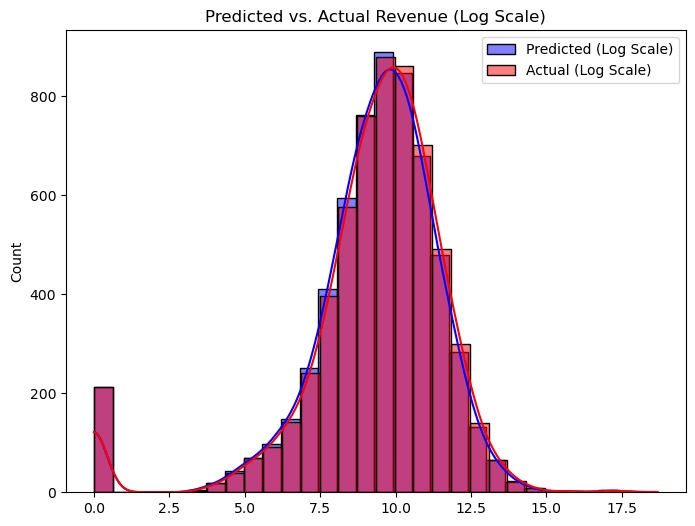

In [117]:
import numpy as np

# Check skewness before and after log transformation
print("Skewness before log transformation:", df_project_revenue['revenue'].skew())
print("Skewness after log transformation:", np.log1p(df_project_revenue['revenue']).skew())

# Ensure predictions match the true revenue scale
y_pred_xgb_adjusted = np.maximum(y_pred_xgb, 0)  # Avoid negative predictions

# Replot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.histplot(np.log1p(y_pred_xgb), bins=30, color='blue', label="Predicted (Log Scale)", kde=True)
sns.histplot(np.log1p(y_test_original), bins=30, color='red', label="Actual (Log Scale)", kde=True)
plt.legend()
plt.title("Predicted vs. Actual Revenue (Log Scale)")
plt.show()


Final R² Score: 0.9899691945804797
Final MAE: 10936.111594863294
Final RMSE: 197227.01908607438


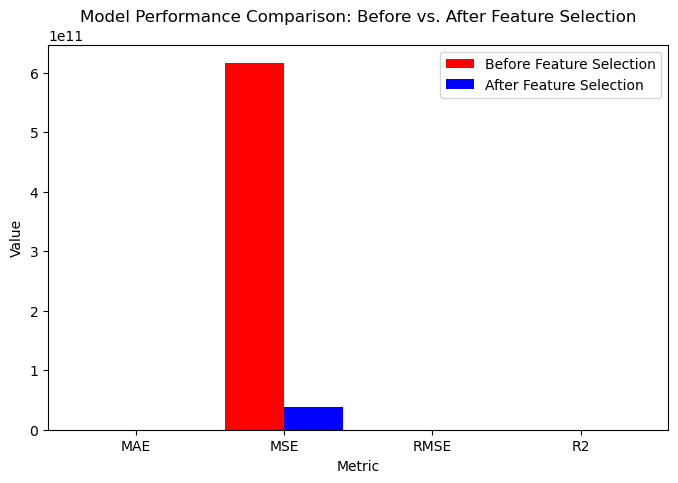

In [201]:
import matplotlib.pyplot as plt
import numpy as np

print(f"Final R² Score: {r2_xgb}")
print(f"Final MAE: {mae_xgb}")
print(f"Final RMSE: {rmse_xgb}")

# Define performance metrics (replace these values with actual results)
metrics = ["MAE", "MSE", "RMSE", "R2"]
before_selection = [81400, 6.16e+11, 785000, -8.95e-03]  
after_selection = [10936, 3.88e10, 197227, 0.99]

x = np.arange(len(metrics))

# Create bar chart
plt.figure(figsize=(8, 5))
plt.bar(x - 0.2, before_selection, 0.4, label="Before Feature Selection", color="red")
plt.bar(x + 0.2, after_selection, 0.4, label="After Feature Selection", color="blue")

plt.xlabel("Metric")
plt.ylabel("Value")
plt.title("Model Performance Comparison: Before vs. After Feature Selection")
plt.xticks(x, metrics)
plt.legend()
plt.show()


In [121]:
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)
print(feature_importance_df)


                                      Feature  Importance
19                             status_Dormant    0.136187
16                project_type_Transportation    0.092999
6   project_type_Infrastructure / Engineering    0.092316
17                       project_type_Unknown    0.074380
18            project_type_Water & Wastewater    0.061629
11                      project_type_Planning    0.054012
21                         source_Sole Source    0.053286
9               project_type_Land Development    0.046426
14         project_type_Survey - Construction    0.046310
15                project_type_Survey - Legal    0.040774
5               project_type_General Services    0.038747
10        project_type_Landscape Architecture    0.032489
8              project_type_Integrated Design    0.032436
0     project_type_Communication & Engagement    0.028270
12                    project_type_Stormwater    0.026012
20                            status_Inactive    0.023902
3             

In [129]:
final_xgb_predictions_df.to_csv("final_xgb_project_revenue_predictions_submission.csv", index=False)
xgb_model_performance.to_csv("final_xgb_model_performance_submission.csv", index=False)

import joblib
joblib.dump(xgb_model, "final_xgb_model_submission.pkl")

feature_importance_df.to_csv("final_feature_importance_submission.csv", index=False)


Index(['Actual Revenue', 'Predicted Revenue'], dtype='object')


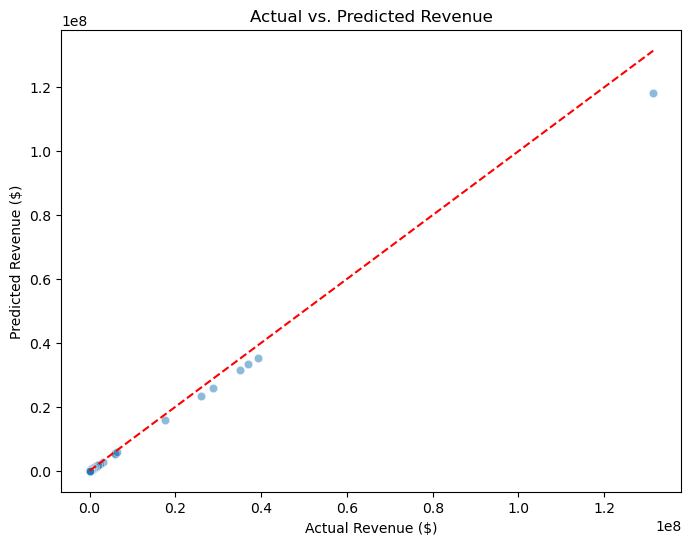

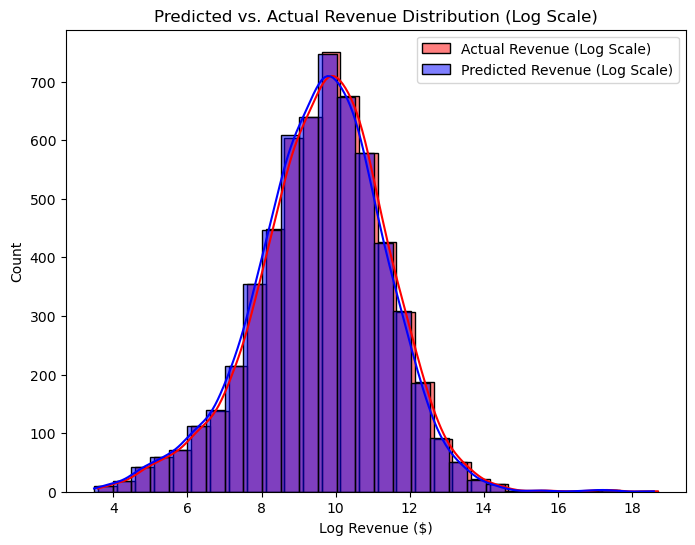

/var/folders/qn/dwvxp6vn44x47pp4nz5_8q9h0000gn/T/ipykernel_52108/1866909023.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feature_importance_df["Feature"], x=feature_importance_df["Importance"], palette="Blues_r")


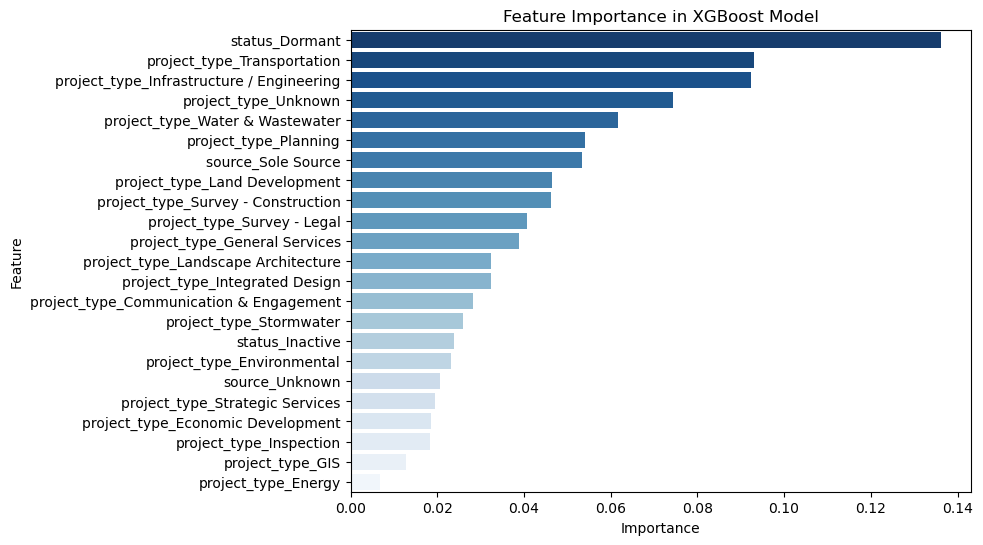

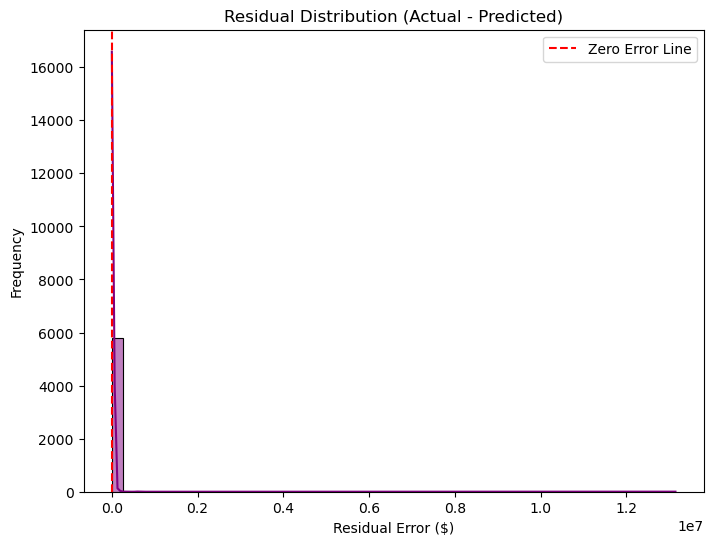

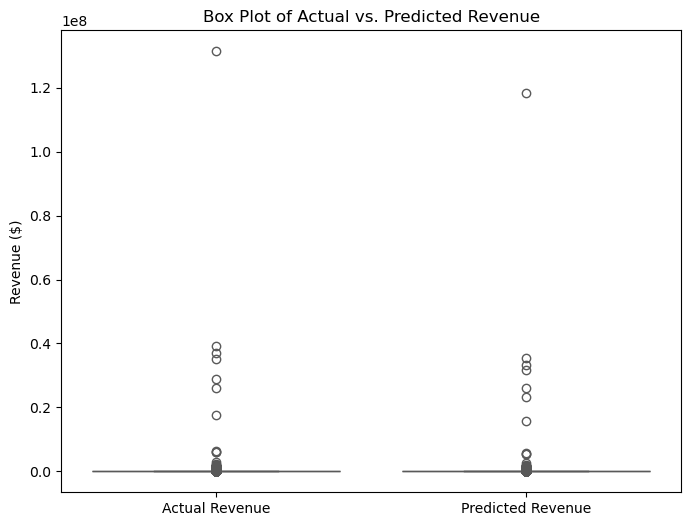

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load final prediction results
predictions_df = pd.read_csv("/Users/brianwang/Desktop/final_xgb_project_revenue_predictions_submission.csv")

# Check column names
print(predictions_df.columns)

# Ensure proper column names
actual_col = [col for col in predictions_df.columns if "actual" in col.lower()][0]
predicted_col = [col for col in predictions_df.columns if "predicted" in col.lower()][0]

# Ensure no zero or negative values for log transformation
predictions_df = predictions_df[predictions_df[actual_col] > 0]
predictions_df = predictions_df[predictions_df[predicted_col] > 0]

# Apply log transformation for better visualization
predictions_df["Log Actual Revenue"] = np.log1p(predictions_df[actual_col])
predictions_df["Log Predicted Revenue"] = np.log1p(predictions_df[predicted_col])

# =========================
# Scatter Plot: Actual vs. Predicted Revenue
# =========================
plt.figure(figsize=(8,6))
sns.scatterplot(x=predictions_df[actual_col], y=predictions_df[predicted_col], alpha=0.5)
plt.plot([0, predictions_df[actual_col].max()], [0, predictions_df[actual_col].max()], 'r--')
plt.xlabel("Actual Revenue ($)")
plt.ylabel("Predicted Revenue ($)")
plt.title("Actual vs. Predicted Revenue")
plt.show()

# =========================
# Histogram: Distribution of Revenue Predictions
# =========================
plt.figure(figsize=(8,6))
sns.histplot(predictions_df["Log Actual Revenue"], bins=30, color='red', label="Actual Revenue (Log Scale)", kde=True)
sns.histplot(predictions_df["Log Predicted Revenue"], bins=30, color='blue', label="Predicted Revenue (Log Scale)", kde=True)
plt.legend()
plt.title("Predicted vs. Actual Revenue Distribution (Log Scale)")
plt.xlabel("Log Revenue ($)")
plt.ylabel("Count")
plt.show()

# =========================
# Feature Importance Visualization
# =========================
feature_importance_df = pd.read_csv("/Users/brianwang/Desktop/final_feature_importance_submission.csv")

plt.figure(figsize=(8, 6))
sns.barplot(y=feature_importance_df["Feature"], x=feature_importance_df["Importance"], palette="Blues_r")
plt.title("Feature Importance in XGBoost Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
# =========================
# Box Plot: Comparing Revenue Predictions
# =========================
plt.figure(figsize=(8,6))
sns.boxplot(data=predictions_df[[actual_col, predicted_col]], palette="Set2")
plt.title("Box Plot of Actual vs. Predicted Revenue")
plt.ylabel("Revenue ($)")
plt.show()


In [139]:
import pandas as pd

# Assuming the final model results are available in a CSV file
xgb_model_performance = pd.read_csv("final_xgb_model_performance_submission.csv")

# Creating a baseline model (Mean-based prediction) for comparison
y_train_mean = y_train.mean()  # Baseline model just predicts the mean

# Compute baseline metrics
baseline_mae = mean_absolute_error(y_test_original, [y_train_mean] * len(y_test_original))
baseline_mse = mean_squared_error(y_test_original, [y_train_mean] * len(y_test_original))
baseline_rmse = np.sqrt(baseline_mse)
baseline_r2 = r2_score(y_test_original, [y_train_mean] * len(y_test_original))

# Create a performance comparison table
model_comparison = pd.DataFrame({
    "Metric": ["MAE", "MSE", "RMSE", "R2"],
    "Baseline Model (Mean Prediction)": [baseline_mae, baseline_mse, baseline_rmse, baseline_r2],
    "XGBoost Optimized Model": xgb_model_performance["XGBoost Optimized Model"]
})

# Display the comparison table in an alternative way

# Creating a simple printout version of the model comparison table
print("\n📊 Model Performance Comparison:")
print(model_comparison.to_string(index=False))

# Save to CSV for easy access
model_comparison.to_csv("model_performance_comparison.csv", index=False)




📊 Model Performance Comparison:
Metric  Baseline Model (Mean Prediction)  XGBoost Optimized Model
   MAE                      1.093525e+05             1.093611e+04
   MSE                      3.889848e+12             3.889850e+10
  RMSE                      1.972270e+06             1.972270e+05
    R2                     -3.080018e-03             9.899692e-01


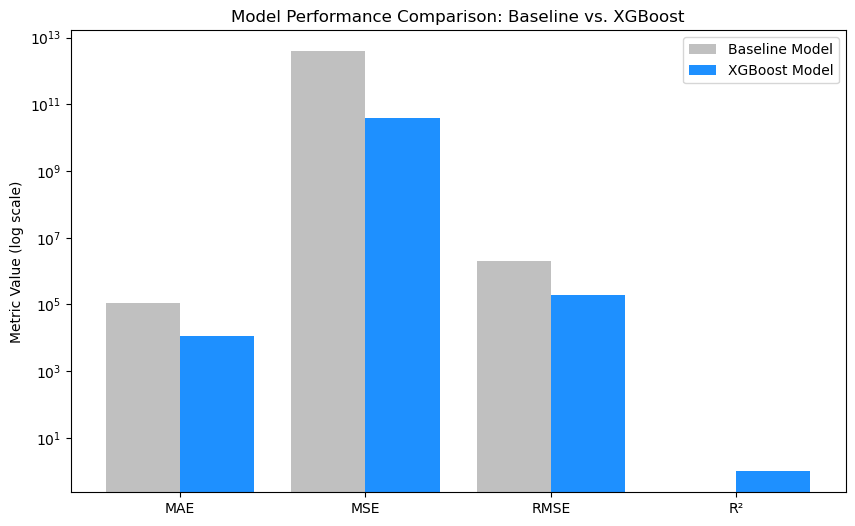

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define model metrics
metrics = ["MAE", "MSE", "RMSE", "R²"]
baseline_values = [1.093525e+05, 3.889848e+12, 1.972270e+06, -0.003]
xgb_values = [1.093611e+04, 3.889850e+10, 1.972270e+05, 0.9899692]

# Create bar chart for comparison 
plt.figure(figsize=(10,6))
x = range(len(metrics))
plt.bar(x, baseline_values, width=0.4, label="Baseline Model", color='#C0C0C0')
plt.bar([i + 0.4 for i in x], xgb_values, width=0.4, label="XGBoost Model", color='#1E90FF')

# Add labels
plt.xticks([i + 0.2 for i in x], metrics)
plt.yscale('log')  # Use log scale for better readability
plt.ylabel("Metric Value (log scale)")
plt.title("Model Performance Comparison: Baseline vs. XGBoost")
plt.legend()
plt.show()


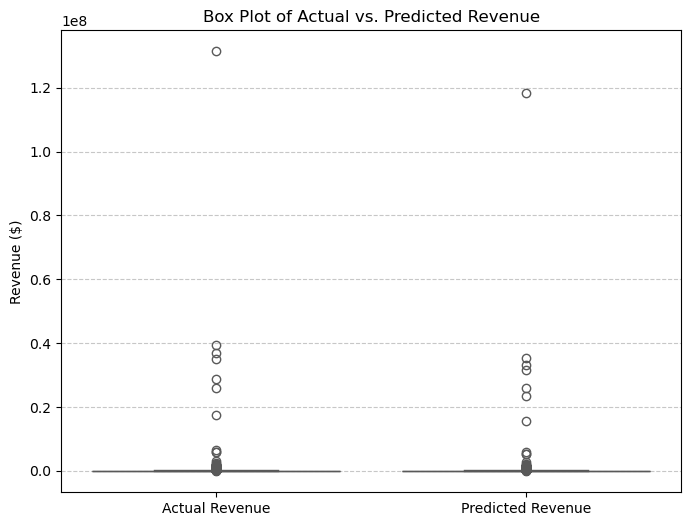

In [153]:
plt.figure(figsize=(8,6))
sns.boxplot(data=[y_test_original, y_pred_xgb], palette="Set2")
plt.xticks([0, 1], ["Actual Revenue", "Predicted Revenue"])
plt.title("Box Plot of Actual vs. Predicted Revenue")
plt.ylabel("Revenue ($)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()